<a href="https://colab.research.google.com/github/Lej/pf2e-token-generator/blob/main/pf2e_token_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sun Sep  3 03:23:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    27W /  70W |   5585MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

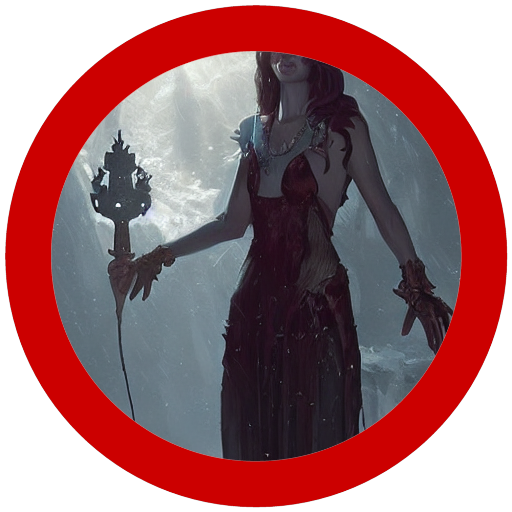

In [7]:
# https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb
import glob
import inspect
import json
import os
import re
import torch
from IPython import get_ipython
from PIL import Image

def get_exit_code():
  return get_ipython().__dict__["user_ns"]["_exit_code"]

def assert_exit_code(message = None):
  exit_code = get_exit_code()
  if exit_code != 0:
    if (message != None):
      raise Exception(f"Expected exit code 0 but got {exit_code}: {message}")
    else:
      raise Exception(f"Expected exit code 0 but got {exit_code}")

def step(step, callback):
  step_name = callback.__name__
  if (step > state["prev_step"]):
    print(f'Running Step {step}: {step_name}')
    result = callback()
    state["prev_step"] = step
    return result
  else:
    print(f"Skipping Step {step}: {step_name}")
    return None

def install():
  !pip install diffusers==0.11.1
  assert_exit_code()
  !pip install transformers scipy ftfy accelerate
  assert_exit_code()

def create_pipe():
  from diffusers import StableDiffusionPipeline
  pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
  return pipe.to("cuda")

def clone_pf2e():
  %cd /content
  !rm -rf ./pf2e
  assert_exit_code()
  !git clone --no-checkout --depth=1 --filter=tree:0 https://github.com/foundryvtt/pf2e.git
  assert_exit_code()
  %cd ./pf2e
  !git sparse-checkout set --no-cone packs
  assert_exit_code()
  !git checkout
  assert_exit_code()
  %cd /content

def clone_pf2e_token_generator():
  %cd /content
  !rm -rf ./pf2e-token-generator
  assert_exit_code()
  !git clone --no-checkout --depth=1 --filter=tree:0 https://github.com/Lej/pf2e-token-generator.git
  assert_exit_code()
  %cd ./pf2e-token-generator
  !git sparse-checkout set --no-cone images
  assert_exit_code()
  !git checkout
  assert_exit_code()
  %cd /content

def get_or_default(root, keys, default):
  current = root
  for key in keys:
    next = current.get(key)
    if next == None:
      return default
    else:
      current = next
  return current

def get_prompt(npc):
  name = get_or_default(npc, ["name"], "")
  traits = get_or_default(npc, ["system", "traits", "value"], [])
  traitsText = " ".join(traits)
  blurb = get_or_default(npc, ["system", "details", "blurb"], "")
  spellcasting = get_or_default(npc, ["system", "spellcasting"], {})
  spellcastingText = " ".join(spellcasting.keys())
  #artist = "Wayne Reynolds"
  artist = "Greg Rutkowski"
  prompt = f"Fantasy art {name} {traitsText} {blurb} {spellcastingText} in the style of {artist}"
  regexes = [
    "\([^\)]*\d[^\)]*\)", # (7-8), (Tier 5-6), (G4), (PFS 1-24, Staff)
    "\(BB|SOT|AoE|PFS\)", # (BB), (SOT), (AoE), (PFS)
    "\s+", # multiple whitespace
    "\(|\)" # (, )
  ]
  for regex in regexes:
    prompt = re.sub(regex, " ", prompt, flags=re.IGNORECASE)
  return prompt

def create_prompts():
  prompts = {}
  for path in glob.glob("/content/pf2e/packs/**/*.json", recursive=True):
    #print(path)
    with open(path) as f:
      doc = json.load(f)
    if (isinstance(doc, dict) and doc.get("type") == "npc"):
      prompts[path] = get_prompt(doc)
  return prompts

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# Run
if not "state" in globals():
  state = {
      "prev_step": 0,
      "images": {}
  }

!nvidia-smi
assert_exit_code("Is runtime type set to GPU?")

step(1, install)
state["pipe"] = step(2, create_pipe) or state["pipe"]
step(3, clone_pf2e)
state["prompts"] = step(4, create_prompts) or state["prompts"]
print(state["prompts"])
step(5, clone_pf2e_token_generator)

images = []
limit = 4
i = 0
generator = torch.Generator("cuda").manual_seed(1024)
for path, prompt in state["prompts"].items():
  image = state["images"].get(path)
  if (image == None):
    image = state["pipe"](prompt, generator=generator).images[0]
    state["images"][path] = image
  images.append(image, )
  i = i + 1
  if i >= 4:
    break

#print(len(images))
#grid = image_grid(images, 4, 1)
#grid

image = images[0]
image

mask = Image.open(r"/content/pf2e-token-generator/images/_background-black-512.png").convert('RGBA')
mask

border = Image.open(r"/content/pf2e-token-generator/images/_border-red-512.png").convert('RGBA')
border

#im3 = Image.composite(image, border, mask)
im3 = Image.composite(image, mask, mask)
im3.paste(border, mask=border)
im3

#print(state["prompts"])

#prompt = "a photograph of an astronaut riding a horse"
#generator = torch.Generator("cuda").manual_seed(1024)
#image = state["pipe"](prompt, generator=generator).images[0]
#image


#image = state["pipe"](prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

# Now to display an image you can either save it such as:
#image.save(f"astronaut_rides_horse.png")

# or if you're in a google colab you can directly display it with







In [71]:
state["prev_step"] = 4
state["images"] = {}

In [ ]:
!git clone --no-checkout --depth=1 --filter=tree:0 https://github.com/foundryvtt/pf2e.git
%cd pf2e
!pwd
!git sparse-checkout set --no-cone packs
!git checkout
%cd ..
!pwd

fatal: destination path 'pf2e' already exists and is not an empty directory.
/content/pf2e
/content/pf2e
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (435/435), done.
remote: Total 479 (delta 0), reused 250 (delta 0), pack-reused 0
Receiving objects: 100% (479/479), 799.87 KiB | 14.28 MiB/s, done.
remote: Enumerating objects: 20215, done.
remote: Counting objects: 100% (20215/20215), done.
remote: Compressing objects: 100% (10828/10828), done.
remote: Total 20215 (delta 15796), reused 9945 (delta 9387), pack-reused 0
Receiving objects: 100% (20215/20215), 24.44 MiB | 5.99 MiB/s, done.
Resolving deltas: 100% (15796/15796), done.
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 1 (delta 0), reused 1 (delta 0), pack-reused 0
Receiving objects: 100% (1/1), 70 bytes | 70.00 KiB/s, done.
Updating files: 100% (20215/20215), done.
Your branch is up to date with 'origin/ma

In [ ]:
!rm -r ./pf2easdasd